In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Bayesian estimate of $\mu$ and $\sigma$.

Let's go through some of the calculations in Gregory's Chapter 9 through a specific example.  There are three cases for estimating $\mu$ discussed in that chapter -- A) known noise $\sigma$ same for all $e_i$ (Section 9.2.1), B) known noise $\sigma_i$ unequal for all $e_i$ (Section 9.2.2), and C) unknown noise $\sigma$ same for all $e_i$ (Section 9.2.3).  Also discussed is a Bayesian estimate of $\sigma$ (Section 9.2.4) for Case C.

Let's implement Cases A and C.  Try to implement Case B yourself at home.

In [2]:
# set a seed so we always get same results
np.random.seed(12345)

mu  = 5.0   # parent population mean
sig = 2.0   # parent population standard deviation

n   = 10

# sample from Gaussian; compute sample mean, variance, and chi^2
d = np.random.normal(loc=mu, scale=sig, size=n)
smu   = np.mean(d)
sigmu = sig/np.sqrt(n)
chi2min = np.sum(((d-smu)/sig)**2)

# print summary
np.set_printoptions(formatter={'float': '{: 0.4f}'.format})
print("                Data  = ", d)
print("            MLE mean  = %8.4f" % smu)
print("   MLE error on mean  = %8.4f" % sigmu)
print(" minimum chi^2 value  = %8.4f" % chi2min)

                Data  =  [ 4.5906  5.9579  3.9611  3.8885  8.9316  7.7868  5.1858  5.5635  6.5380
  7.4929]
            MLE mean  =   5.9897
   MLE error on mean  =   0.6325
 minimum chi^2 value  =   6.4402


In [3]:
# upper and lower bounds for mu and sigma priors
muL  = 0.0
muH  = 10.0
sigL = 0.1
sigH = 6.0

# generate grid of mu and sigma values that extend beyond
# the non-zero prior ranges for plotting purposes
# we will use them throughout this notebook
mugrid  = np.linspace(0, 20, num=1001, endpoint=True)
siggrid = np.linspace(0.1, 10, num=1001, endpoint=True)

In [4]:
def priorUniform(mu, mumin=muL, mumax=muH):
    # uniform prior
    prior = np.zeros_like(mu)+1.0/(mumax-mumin)
    # make sure to set prior outside range to zero
    prior[mu<mumin] = prior[mu>mumax] = 0.0
    return prior

In [5]:
def priorJeffreys(sig, sigmin=sigL, sigmax=sigH):
    # Jeffreys prior
    prior = 1.0/(sig*np.log(sigmax/sigmin))
    # make sure to set prior outside range to zero
    prior[sig<sigmin] = prior[sig>sigmax] = 0.0
    return prior

In [6]:
priormu  = priorUniform(mugrid)
priorsig = priorJeffreys(siggrid)

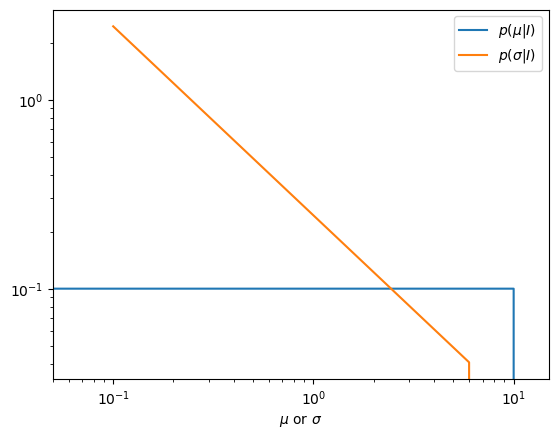

In [7]:
plt.plot(mugrid, priormu, label='$p(\mu|I)$')
plt.plot(siggrid, priorsig, label='$p(\sigma|I)$')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.05, 15])
plt.xlabel('$\mu$ or $\sigma$')
plt.legend()

In [8]:
# check prior normalization
print("   prior(mu) integral = ", np.trapz(priormu, mugrid))
print("prior(sigma) integral = ", np.trapz(priorsig, siggrid))
# If you want to be precise, you can divide the prior values
# by these normalization factors.  Alternatively, you can
# properly account for the prior values at the bins that
# contain muL, muH, sigL, sigH.  But it will have only a
# tiny effect.

   prior(mu) integral =  1.001
prior(sigma) integral =  1.0000140305235403


## Case A : $e_i = \sigma$, same for all $i$

The posterior is given by, $$p(\mu|D,I) = \frac{e^{-Q/(2\sigma^2)}}{\int_{\mu_L}^{\mu_H} e^{-Q/(2\sigma^2)}d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$Q = \sum_{i=1}^n (d_i-\mu)^2$$

The simplified form is Equation (9.8), $$p(\mu|D,I) = \frac{\mathrm{exp}\left\{-\frac{(\mu-\bar{d})^2}{2\sigma^2/N}\right\}}{\int_{\mu_L}^{\mu_H}\mathrm{exp}\left\{-\frac{(\mu-\bar{d})^2}{2\sigma^2/N}\right\}d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$\bar{d} = \frac{1}{N}\sum_{i=1}^{N} d_i$$

Let's implement both expressions; call them A1 and A2, respectively.  Keep in mind that NUM is zero outside the prior range.

In [9]:
NUM = np.zeros_like(mugrid)

# we are computing p(mu), so loop over mugrid values
for i in range(len(mugrid)):
    Q = np.sum((d - mugrid[i])**2)
    NUM[i] = np.exp(-Q/(2*sig*sig))
    
# make sure you multiply this by the prior
NUM = priormu*NUM

DEN = np.trapz(NUM, mugrid)
posteriorA1 = NUM/DEN

In [10]:
# check normalization; this should come out to exactly 1.0
print(np.trapz(posteriorA1, mugrid))

1.0


Text(4.7, 0.5, 'true $\\mu=5$')

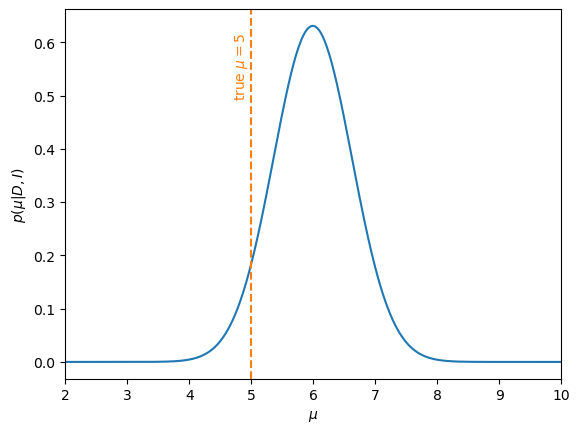

In [11]:
plt.plot(mugrid, posteriorA1)
# you can overplot the following to see that the posterior
# is a gaussian.
#plt.plot(mugrid, stats.norm.pdf(mugrid, loc=smu, scale=sigmu))
plt.xlim([2,10])
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
plt.axvline(x=mu, ls='--', c='#ff7f0e')
plt.text(4.7, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')

This is the implementation of the second expression, which will of course yield the exact same results.

In [12]:
dbar = d.mean() # = smu
NUM = priormu*np.exp(-n*(mugrid-dbar)**2/(2*sig*sig))
DEN = np.trapz(NUM, mugrid)
posteriorA2 = NUM/DEN

In [13]:
# check normalization
print(np.trapz(posteriorA2, mugrid))

1.0


Text(4.7, 0.5, 'true $\\mu=5$')

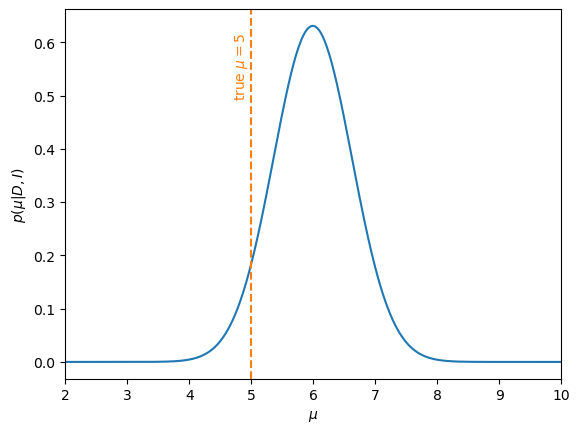

In [14]:
plt.plot(mugrid, posteriorA2)
plt.xlim([2,10])
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
plt.axvline(x=mu, ls='--', c='#ff7f0e')
plt.text(4.7, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')

## Case B : $e_i = \sigma_i$, unequal for all $i$

The posterior is given by, $$p(\mu|D,I) = \frac{e^{-Q^\prime/2}}{\int_{\mu_L}^{\mu_H} e^{-Q^\prime/2} d\mu}$$ where $$Q^\prime = \sum_{i=1}^{N} \left(\frac{d_i-\mu}{\sigma_i}\right)^2$$

The posterior, after simplification, is given by Equation (9.19), $$p(\mu|D,I) = \frac{\mathrm{exp}\left\{-\frac{(\mu-\bar{d_w})^2}{2\sigma_w^2}\right\}}{\int_{\mu_L}^{\mu_H}\mathrm{exp}\left\{-\frac{(\mu-\bar{d_w})^2}{2\sigma_w^2}\right\}d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$\bar{d_w} = \frac{\sum_{i=1}^{N} w_i d_i}{\sum_{i=1}^{N} w_i}$$  $$\sigma_w^2 = \frac{1}{\sum_{i=1}^N w_i}$$ and $$w_i = \frac{1}{\sigma_i^2}$$  SEE IF YOU CAN IMPLEMENT THIS YOURSELF!

## Case C : $e_i = \sigma$, equal for all $i$ but unknown.

The posterior for $\mu$ marginalized over $\sigma$ is given by Equation (9.32), $$p(\mu|D,I) = \frac{p(\mu|I) \int_{\sigma_L}^{\sigma_H} p(\sigma|I) \sigma^{-N} e^{-Q/2\sigma^2} d\sigma}{\int_{\mu_L}^{\mu_H} p(\mu|I) \int_{\sigma_L}^{\sigma_H} p(\sigma|I) \sigma^{-N} e^{-Q/2\sigma^2} d\sigma d\mu} = \frac{\int_{\sigma_L}^{\sigma_H} \sigma^{-(N+1)} e^{-Q/2\sigma^2} d\sigma}{\int_{\mu_L}^{\mu_H} \int_{\sigma_L}^{\sigma_H} \sigma^{-(N+1)} e^{-Q/2\sigma^2} d\sigma d\mu} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$ where $$Q = \sum_{i=1}^{N} (d_i-\mu)^2$$  Again, keep in mind that NUM is zero outside the prior range.

In [15]:
NUM = np.zeros_like(mugrid)

# we are computing p(mu), so loop over mugrid values
for i in range(len(mugrid)):
    Q = np.sum((d - mugrid[i])**2)
    integrand = priorsig/(siggrid**n) * np.exp(-Q/(2*siggrid*siggrid))
    NUM[i] = np.trapz(integrand, siggrid)

NUM = priormu*NUM

DEN = np.trapz(NUM, mugrid)
posteriorC = NUM/DEN

In [16]:
# always check normalization
print(np.trapz(posteriorC, mugrid))

1.0000000000000002


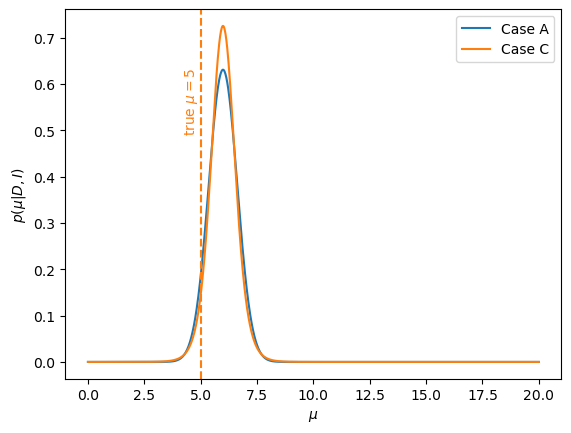

In [17]:
plt.plot(mugrid, posteriorA2, label='Case A')
plt.plot(mugrid, posteriorC, label='Case C')
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
plt.axvline(x=mu, ls='--', c='#ff7f0e')
plt.text(4.2, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')
#plt.yscale('log')
plt.legend()

Note that the posterior PDF for Case C is similar to Case A (in fact, it is narrower than).  This is because the value of $\sigma = 2$ given correctly describes the scatter in the data points.

If, however, you were given the same set of data points $D$ but with, say, $\sigma = 1$ (which underestimates the scatter), the PDF for Case A would have been incorrectly narrower.  Let's see this by recomputing the PDF for A assuming $\sigma = 1$.  We are calling this posterior A3.

In [18]:
NUM = np.zeros_like(mugrid)

sigwrong = 1.0

# we are computing p(mu), so loop over mugrid values
for i in range(len(mugrid)):
    Q = np.sum((d - mugrid[i])**2)
    NUM[i] = np.exp(-Q/(2*sigwrong*sigwrong))
    
# make sure you multiply this by the prior
NUM = priormu*NUM

DEN = np.trapz(NUM, mugrid)
posteriorA3 = NUM/DEN

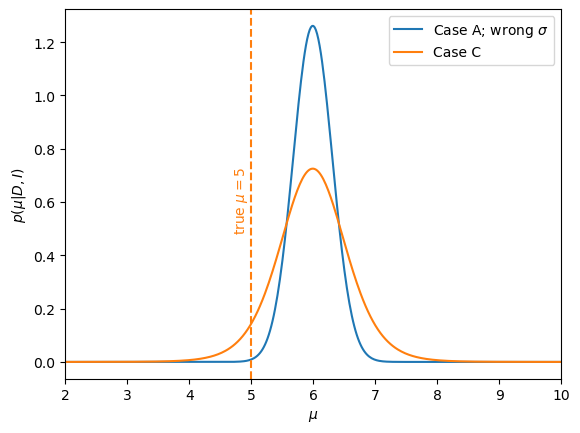

In [19]:
plt.plot(mugrid, posteriorA3, label='Case A; wrong $\sigma$')
plt.xlim([2,10])
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
plt.axvline(x=mu, ls='--', c='#ff7f0e')
plt.text(4.7, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')
# overplot Case C
plt.plot(mugrid, posteriorC, label='Case C')
plt.legend()

The book goes ahead and shows that the PDF for Case C is a Student's t distribution with $$\frac{t^2}{\nu} = \frac{\mu-\bar{d}}{r^2}$$ with $\nu=N-1$ degrees of freedom and $$r^2 = \frac{1}{N} \sum_{i=1}^{N} (d_i - \bar{d})^2$$ is the mean square deviation from $\bar{d}$.  You can see the comparison here.  Note that our PDF is truncated because of our choice of prior.

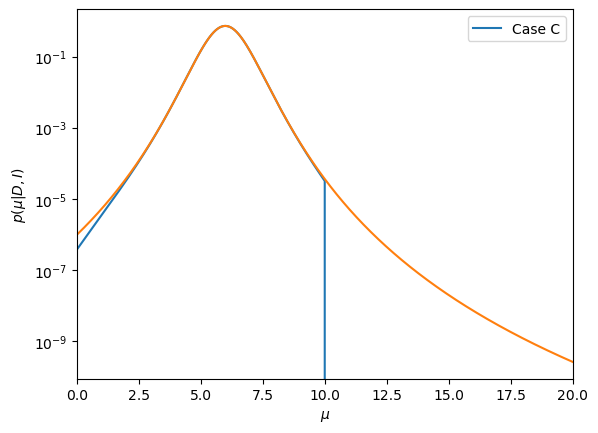

In [20]:
#plt.plot(mugrid, posteriorA1, label='Case A')
plt.plot(mugrid, posteriorC, label='Case C')
plt.xlim([0,20])
plt.xlabel('$\mu$')
plt.ylabel('$p(\mu|D,I)$')
#plt.axvline(x=mu, ls='--', c='#ff7f0e')
#plt.text(4.7, 0.5, 'true $\mu=5$', rotation=90, c='#ff7f0e')
r2  = (1/n)*np.sum((d-dbar)**2)
plt.plot(mugrid, stats.t.pdf(mugrid, df=n-1, loc=dbar, scale=np.sqrt(r2/(n-1))))
plt.yscale('log')
plt.legend()

## Calculation of $p(\sigma|D,I)$

We can also compute the posterior for $\sigma$ marginalized over $\mu$, $$p(\sigma|D,I) = \frac{p(\sigma|I) \sigma^{-N} \int_{\mu_L}^{\mu_H}  e^{-Q/2\sigma^2} d\mu}{\int_{\sigma_L}^{\sigma_H} p(\sigma|I) \sigma^{-N}\int_{\mu_L}^{\mu_H} e^{-Q/2\sigma^2} d\mu d\sigma} = \frac{\sigma^{-(N+1)} \int_{\mu_L}^{\mu_H}  e^{-Q/2\sigma^2} d\mu}{\int_{\sigma_L}^{\sigma_H} \int_{\mu_L}^{\mu_H} \sigma^{-(N+1)} e^{-Q/2\sigma^2} d\mu d\sigma} = \frac{\mathrm{NUM}}{\mathrm{DEN}}$$


In [21]:
NUM = np.zeros_like(siggrid)
Q   = np.zeros_like(mugrid)

# we are computing p(sigma), so loop over siggrid values
for i in range(len(siggrid)):
    
    for j in range(len(mugrid)):
        Q[j] = np.sum((d - mugrid[j])**2)
        
    integrand = priormu/(siggrid[i]**n) * np.exp(-Q/(2*siggrid[i]*siggrid[i]))
    NUM[i] = priorsig[i]*np.trapz(integrand, mugrid)

DEN = np.trapz(NUM, siggrid)
posteriorSig1 = NUM/DEN

In [22]:
# always check normalization
print(np.trapz(posteriorSig1, siggrid))

1.0


Text(1.3, 0.0, '$\\sigma=r$')

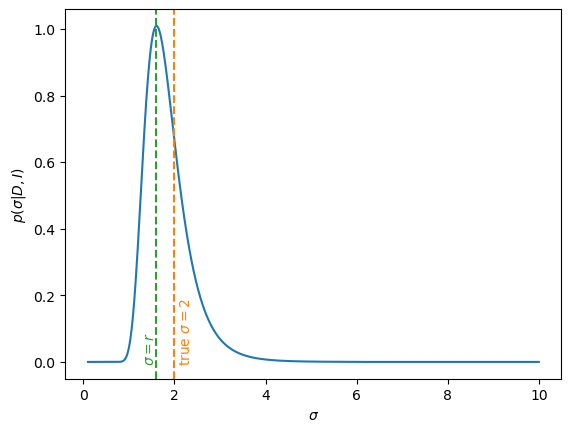

In [23]:
plt.plot(siggrid, posteriorSig1)
plt.xlabel('$\sigma$')
plt.ylabel('$p(\sigma|D,I)$')
plt.axvline(x=sig, ls='--', c='#ff7f0e')
plt.text(2.1, 0.0, 'true $\sigma=2$', rotation=90, c='#ff7f0e')
# the most-probable value is r=sqrt(r2)
r2  = (1/n)*np.sum((d-dbar)**2)
plt.axvline(x=np.sqrt(r2), ls='--', c='#2ca02c')
plt.text(1.3, 0.0, '$\sigma=r$', rotation=90, c='#2ca02c')

The simplified form is Equation (9.43), which assumes that $p(\mu|I)$ cancels out.  $$p(\sigma|D,I) = \frac{\frac{1}{\sigma^N} e^{-Nr^2/2\sigma^2}}{\int_{\sigma_L}^{\sigma_H} \frac{1}{\sigma^N} e^{-Nr^2/2\sigma^2} d\sigma}$$ where $$r^2 = \frac{1}{N} \sum_{i=1}^{N} (d_i-\bar{d})^2$$

In [24]:
r2  = (1/n)*np.sum((d-dbar)**2)
NUM = priorsig*np.exp(-n*r2/(2*siggrid*siggrid))/(siggrid**(n-1))
DEN = np.trapz(NUM, siggrid)
posteriorSig = NUM/DEN

Text(1.3, 0.0, '$\\sigma=r$')

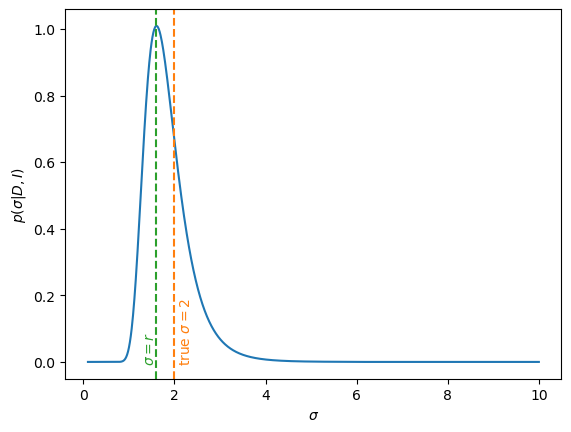

In [25]:
plt.plot(siggrid, posteriorSig)
plt.xlabel('$\sigma$')
plt.ylabel('$p(\sigma|D,I)$')
plt.axvline(x=sig, ls='--', c='#ff7f0e')
plt.text(2.1, 0.0, 'true $\sigma=2$', rotation=90, c='#ff7f0e')
# the most-probable value is r=sqrt(r2)
r2  = (1/n)*np.sum((d-dbar)**2)
plt.axvline(x=np.sqrt(r2), ls='--', c='#2ca02c')
plt.text(1.3, 0.0, '$\sigma=r$', rotation=90, c='#2ca02c')

Finally, let's also look at the joint likelihood $p(D|\mu, \sigma, I)$ ignoring the priors.  $$\mathcal{L}(\mu, \sigma) \propto \frac{1}{\sigma^n} e^{-Q/(2\sigma^2)}$$

In [26]:
def likelihood(mu, sig, d, n):
    dbar = d.mean()
    r2 = (1/n)*np.sum((d-dbar)**2)
    Q  = n*((mu-dbar)**2) + n*r2  # this is the alternate expression derived in the book
    L  = (1/sig**n) * np.exp(-Q/(2*sig*sig))
    return L

In [27]:
X, Y = np.meshgrid(mugrid, siggrid)
like = likelihood(X, Y, d, n)

In [28]:
like.shape

(1001, 1001)

(0.0, 4.0)

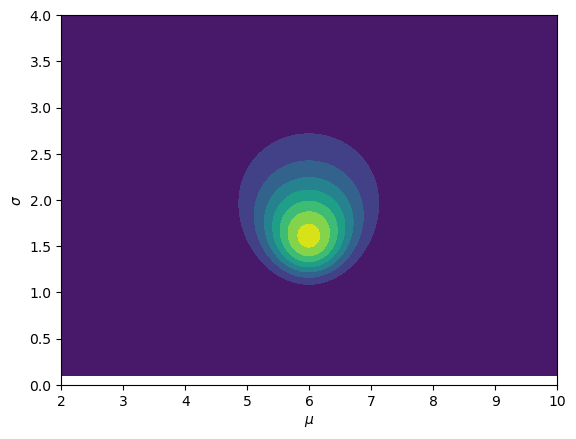

In [29]:
fig = plt.figure()
ax  = fig.add_subplot()
ax.contourf(X, Y, like)
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_xlim([2, 10])
ax.set_ylim([0, 4])